# Propagation d'incertitude : Fiabilité

Ce *notebook* vise à illustrer les méthodes associée à l'approche dite de ***"Couplage mécano-fiabiliste"*** sur des exemples simples en 2 dimensions permettant de visualiser les étapes, les hypothèses et les limites des méthodes vues au cours de la formation fiabilité.

Les méthodes utilisées sont :

- la simulation de Monte Carlo
- les simulations directionnelles
- la méthode FORM / SORM
- la simulation par tirages d'importance
- la simulation par sous-ensembles (subset)

In [1]:
import openturns as ot
#from otsubset import SubsetSampling
from openturns.viewer import View
import numpy as np
from matplotlib import pyplot as plt
%pylab --no-import-all inline
from mpl_toolkits.mplot3d import Axes3D
rcParams = { 'axes.grid': False,
             #'axes.hold': True,
             'axes.labelsize': 16,
             'xtick.labelsize': 12,
             'ytick.labelsize': 12,
             'axes.linewidth': 0.5,
             'font.size': 16,
             'image.cmap': 'gray',
             'image.interpolation': 'bilinear',
             'legend.fontsize': 16,
             'legend.shadow': True,
             'lines.linewidth': 1.5,
             'text.latex.unicode': True}
plt.rcParams.update(rcParams)
light_gray = plt.matplotlib.colors.LinearSegmentedColormap.from_list(
                'light_gray', [[.9] * 3, [.6] * 3])
class FormatFaker(object):
    def __init__(self, str): self.str = str
    def __mod__(self, stuff): return self.str

Populating the interactive namespace from numpy and matplotlib


/home/blondet/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]


# 1. Définition d'un problème de fiabilité

## 1.1. Définition du modèle probabiliste des paramètres d'entrée

Dans OpenTURNS, un modèle probabiliste est courrament défini comme une `ComposedDistribution`:

1. On commence par définir les distributions *marginales* (univariées) de chacune des variables (`Normal`, `LogNormal`, `Weibull`, etc. ...);
2. On complète éventuellement la définition par une structure de dépendance stochastique en utilisant le formalisme des copules (par défaut OpenTURNS supposera que les variables sont indépendantes en utilisant une `IndependentCopula`).

In [2]:
R = ot.LogNormal()
R.setParameter(ot.LogNormalMuSigma()([7.7, .55, 0.]))
R.setDescription(['Resistance'])

S = ot.LogNormal()
S.setParameter(ot.LogNormalMuSigma()([1.1, .55, 0.]))
S.setDescription(['Contrainte'])

spearman_rank_correlation = ot.CorrelationMatrix(2)
spearman_rank_correlation[0, 1] = .525
normal_copula_correlation = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(spearman_rank_correlation)
copula = ot.NormalCopula(normal_copula_correlation)
input_distribution = ot.ComposedDistribution([R, S], copula)

print(input_distribution)

ComposedDistribution(LogNormal(muLog = 2.03868, sigmaLog = 0.0713377, gamma = 0), LogNormal(muLog = -0.0162616, sigmaLog = 0.472381, gamma = 0), NormalCopula(R = [[ 1        0.542881 ]
 [ 0.542881 1        ]]))


## 1.2. Définition de la fonction d'état-limite

En fiabilité, la **fonction d'état-limite permet de caractériser la défaillance**. Dans OpenTURNS, on la définit comme une fonction mathématique (`NumericalMathFunction`). Attention à la définition du gradient et du hessien dans le cas d'une fonction python. Certaines méthodes de fiabilité les utilisent.

NB: Par convention, de nombreux auteurs en fiabilité des structures définissent leur fonction d'état-limite de façon à ce que la **défaillance soit caractérisée par des valeurs négatives** de la fonction d'état-limite.
OpenTURNS permet de se faire sa propre convention en renseignant explicitement la valeur seuil et l'opérateur de comparaison au moment de la définition de l'évènement redouté.

In [3]:
# A partir d'une formule analytique simple (une ligne)...
g = ot.SymbolicFunction(['r', 's'], ['-r^2 - s^2+100'])
g = ot.MemoizeFunction(g)
g.enableCache()

print( 'Fonction', g)
print( 'gradient', g.getGradient())
print( 'Hessien', g.getHessian())

Fonction [r,s]->[-r^2 - s^2+100]
gradient 
| d(y0) / d(r) = -2*r
| d(y0) / d(s) = -2*s

Hessien 
|   d^2(y0) / d(r)^2 = -2
| d^2(y0) / d(s)d(r) = 0
|   d^2(y0) / d(s)^2 = -2



In [4]:
# A partir d'une fonction numérique implémentée en Python
def g_(X):
    """Fonction d'état limite implémentée en Python."""
    X = np.atleast_2d(X)
    return np.atleast_2d(-X[:, 0]**2 - X[:, 1]**2+100).T

g = ot.PythonFunction(n=2, p=1, func_sample=g_)
g.setDescription(['r', 's', 'g'])
g = ot.MemoizeFunction(g)
g.enableCache()
print('Fonction', g)
print('gradient', g.getGradient())
print('Hessien', g.getHessian())

Fonction class=PythonEvaluation name=OpenTURNSPythonFunction
gradient CenteredFiniteDifferenceGradient epsilon : [1e-05,1e-05]
Hessien CenteredFiniteDifferenceHessian epsilon : [0.0001,0.0001]


Le calcul des dérivées partielles de la fonction ainsi déclarée se fait par différence finie dans le cas d'une fonction implicite. Le schéma (et le pas) de différence finie peut être (et **doit être**) personnalisé !

In [5]:
g.setGradient(
    ot.NonCenteredFiniteDifferenceGradient(
        np.array(input_distribution.getStandardDeviation()) * 5e-4,
        g.getEvaluation()))
g.setHessian(
    ot.CenteredFiniteDifferenceHessian(
        np.array(input_distribution.getStandardDeviation()) * 5e-4,
        g.getEvaluation()))
g.setDescription(['r', 's', 'g'])
print('Fonction', g)
print('gradient', g.getGradient())
print('Hessien', g.getHessian())

Fonction class=PythonEvaluation name=OpenTURNSPythonFunction
gradient NonCenteredFiniteDifferenceGradient epsilon : [0.000275,0.000275]
Hessien CenteredFiniteDifferenceHessian epsilon : [0.000275,0.000275]


A l'usage...

In [6]:
print('Valeur de la fonction à la moyenne:')
print(g(input_distribution.getMean()))

print('Valeur du gradient à la moyenne:')
print(g.gradient(input_distribution.getMean()))

print('Valeur du hessien à la moyenne:')
print(g.hessian(input_distribution.getMean()))

Valeur de la fonction à la moyenne:
[39.5]
Valeur du gradient à la moyenne:
[[ -15.4003  ]
 [  -2.20027 ]]
Valeur du hessien à la moyenne:
sheet #0
[[ -2  0 ]
 [  0 -2 ]]


## 1.3. Définition de la marge

On appelle **marge**, la variable décrivant la marge de sûreté d'une réalisation. C'est donc le résultat de l'évaluation de la fonction d'état-limite. Dans le contexte d'une analyse de fiabilité, les variables d'entrée de la fonction d'état-limite étant aléatoires, la *marge* est elle aussi une variable aléatoire.

Dans OpenTURNS, on l'implémente comme un **vecteur aléatoire** (`RandomVector`) définit par propagation. Contrairement à la distribution des paramètres d'entrée, on ne connait pas la distribution de ce vecteur aléatoire, donc on ne connait pas ses fonctions de densité, de répartition, ses moments, etc. ... On peut néanmoins en générer des réalisations (par propagation).

/home/blondet/anaconda3/lib/python3.7/site-packages/openturns/viewer.py:559: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self._fig.show(**kwargs)


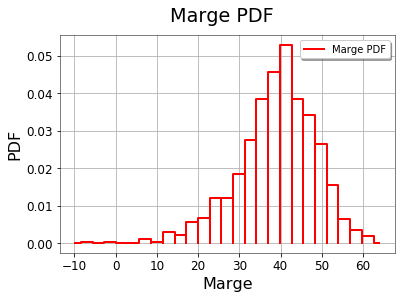

In [7]:
G = ot.CompositeRandomVector(g, ot.RandomVector(input_distribution))
G.setDescription(['Marge'])
sample = G.getSample(1000)
View(ot.HistogramFactory().build(sample).drawPDF(), bar_kwargs={'label':'G'}).show()

## 1.4. Définition de l'évènement redouté

Enfin, pour compléter la définition d'un problème de fiabilité, on définit l'évènement redouté comme un `Event` OpenTURNS qui va synthétiser toute la modélisation. C'est donc ce seul objet qui sera transmis à l'ensemble des algorithmes de fiabilité utilisables dans OpenTURNS et PhimecaSoft.

In [8]:
failure_event = ot.Event(G, ot.LessOrEqual(), 0.)
failure_event.setDescription(["La contrainte dépasse la résistance"])

# Autres exemples

## Der Kiureghian & Dakessian (1998)

Un exemple à deux "points de défaillance les plus probables" pour montrer les limites des approches basées sur l'hypothèse d'unicité d'un tel point (FORM, SORM, et MPFP-IS)

Dans cet exemple, la fonction d'état-limite est définie comme suit:

$g(x_1, x_2) = b - x_2 - \kappa\,(x_1 - e) ^ 2$,

et $\mathbf{X} \sim \mathcal{N}_2(\mathbf{0}, \mathbf{1})$.

Le paramètre d'excentricité $e > 0$ permet de favoriser l'influence un point de défaillance plutôt qu'un autre dans la probabilité, le coefficient $\kappa > 0$ contrôle la courbure de l'état-limite.

In [9]:
input_distribution = ot.Normal(2)

def g_(X):
    X = np.atleast_2d(X)
    b, kappa, e = 5., .5, .1
    return np.atleast_2d(b - X[:, 1] - kappa * (X[:, 0] - e) ** 2.).T
g = ot.PythonFunction(n=2, p=1, func_sample=g_)

g = ot.MemoizeFunction(g)
g.enableCache()

g.setGradient(
    ot.NonCenteredFiniteDifferenceGradient(
        np.array(input_distribution.getStandardDeviation()) * 1e-2,
        g.getEvaluation()))
g.setHessian(
    ot.CenteredFiniteDifferenceHessian(
        np.array(input_distribution.getStandardDeviation()) * 1e-2,
        g.getEvaluation()))

G = ot.CompositeRandomVector(g, ot.RandomVector(input_distribution))

failure_event = ot.Event(G, ot.LessOrEqual(), 0.)

## Du disque au rectangle (perte de gradient)

Un état-limite de type "circulaire" que l'on peut faire tendre vers un "rectangle" en manipulant l'exposant $k$.

Dans cet exemple, la fonction d'état-limite est définie comme suit:

$g(x_1, x_2) = s\,\left[\left((x_1 - c_1)^{2\,k} + (x_2 - c_2)^{2\,k}\right) - r^{2\,k}\right]$,

et $\mathbf{X} \sim \mathcal{N}_2(\mathbf{0}, \mathbf{1})$.

Le coefficient $s \in \{-1; 1\}$ contrôle le sens dans lequel on définit la défaillance: l'intérieur ($s = 1$) ou l'extérieur ($s = -1$) du cercle de centre de coordonnées $\mathbf{c} = (c_1,\,c_2)^{\mathrm T}$.

En augmentant l'exposant $k$, la fonction d'état-limite s'applatit au voisinage du centre  rendant ainsi la plupart des méthodes fiabilistes impuissantes, car la plupart s'appuie sur l'existence d'un gradient non-nul pour guider progressivement les simulations vers la défaillance.

In [10]:
input_distribution = ot.Normal(2)

def g_(X):
    X = np.atleast_2d(X)
    center = np.atleast_2d([0., 0.])
    radius = 3.
    k = 3.
    s = - 1.
    return s * np.atleast_2d(np.sum((X - center) ** (2. * k), axis=1) - radius ** (2. * k)).T

g = ot.PythonFunction(n=2, p=1, func_sample=g_)

g = ot.MemoizeFunction(g)
g.enableCache()

g.setGradient(
    ot.NonCenteredFiniteDifferenceGradient(
        np.array(input_distribution.getStandardDeviation()) * 5e-2,
        g.getEvaluation()))
g.setHessian(
    ot.CenteredFiniteDifferenceHessian(
        np.array(input_distribution.getStandardDeviation()) * 5e-2,
        g.getEvaluation()))

G = ot.CompositeRandomVector(g, ot.RandomVector(input_distribution))

failure_event = ot.Event(G, ot.LessOrEqual(), 0.)

# 2. Transformation isoprobabiliste et représentations 2D du problème

La **transformation isoprobabiliste** programmée dans OpenTURNS permet systématiquement de se ramener d'un vecteur aléatoire quelconque à un vecteur aléatoire gaussien de moyenne nulle et de covariance unitaire.

Cette standardisation du problème permet:

- de construire de bonnes approximations de la probabilité de l'évènement redouté (voir les méthodes FORM/SORM) ;
- de régler les autres algorithmes de manière robuste (*i.e.* indépendamment de l'ordre de grandeur des variables du problème).

La fonction qui permet la transformation s'obtient à partir de la `ComposedDistribution` avec la méthode `getIsoProbabilisticTransformation`. La transformation inverse s'obtient avec la méthode `getInverseIsoProbabilisticTransformation`.

Examinons ses effets par des représentations 2D.

In [11]:
def plot_in_standard_space(lim=6, res=50, ax=None, g0=0., approx=None):
    
    if ax is None:
        ax = plt.figure(figsize=(8, 8)).add_subplot(111)
    
    u1_plot, u2_plot = np.meshgrid(np.linspace(-lim, lim, res), np.linspace(-lim, lim, res))
    uu_plot = np.vstack([u1_plot.ravel(), u2_plot.ravel()]).T
    Tinv = input_distribution.getInverseIsoProbabilisticTransformation()
    gu_plot = np.reshape(g(Tinv(uu_plot)), (res, res))
    fu_plot = np.reshape(ot.Normal(2).computePDF(uu_plot), (res, res))
    im = ax.imshow(np.flipud(fu_plot), cmap=light_gray, extent=(-lim, lim, -lim, lim))
    cb = plt.colorbar(im)
    cb.set_label('$\\varphi(\mathbf{u})$')
    ax.contourf(u1_plot, u2_plot, gu_plot, [-np.inf, g0], colors='r', alpha=.2)
    c = ax.contour(u1_plot, u2_plot, gu_plot, [g0], colors='r', linestyles='solid', lw=2.)
    plt.clabel(c, fmt=FormatFaker('$g^{\circ}(\mathbf{u}) = %.2f$' % g0), colors='k')
    
    if approx is not None:
        # bug RuntimeError: InternalException : Python exception: TypeError: unsupported operand type(s) for -: 'openturns.memoryview.Buffer' and 'Point'
        approx_plot = np.reshape(approx(uu_plot), (res, res))
        ax.contour(u1_plot, u2_plot, approx_plot, [g0], colors='b', linestyles='--', lw=2.)
        ax.contourf(u1_plot, u2_plot, approx_plot, [-np.inf, g0], colors='b', alpha=.2)
    
    ax.set_title('Standard space')
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_aspect(1.)
    ax.set_xlabel('$u_1$')
    ax.set_ylabel('$u_2$')
    origin = np.zeros(2)
    ax.plot(origin[0], origin[1], 'k.', markersize=15)
    plt.text(origin[0], origin[1], '$\mathbf{O}$', ha='left', va='bottom', fontdict={'fontsize': 14})
    plt.axvline(origin[0], color='k', linestyle='dashdot', linewidth=1.)
    plt.axhline(origin[1], color='k', linestyle='dashdot', linewidth=1.)
    return ax, locals()

In [12]:
def plot_in_physical_space(lim=6, res=50, ax=None, g0=0.):
    if ax is None:
        ax = plt.figure(figsize=(8, 8)).add_subplot(111)
    x1_lim = (input_distribution.getMarginal(0).computeQuantile(ot.Normal().computeCDF(-lim))[0],
              input_distribution.getMarginal(0).computeQuantile(1. - ot.Normal().computeCDF(-lim))[0])
    x2_lim = (input_distribution.getMarginal(1).computeQuantile(ot.Normal().computeCDF(-lim))[0],
              input_distribution.getMarginal(1).computeQuantile(1. - ot.Normal().computeCDF(-lim))[0])
    x1_plot, x2_plot = np.meshgrid(np.linspace(x1_lim[0], x1_lim[1], res),
                                   np.linspace(x2_lim[0], x2_lim[1], res))
    xx_plot = np.vstack([x1_plot.ravel(), x2_plot.ravel()]).T
    gx_plot = np.reshape(g(xx_plot), (res, res))
    fx_plot = np.reshape(input_distribution.computePDF(xx_plot), (res, res))
    im = ax.imshow(np.flipud(fx_plot), cmap=light_gray, extent=(x1_lim[0], x1_lim[1], x2_lim[0], x2_lim[1]))
    cb = plt.colorbar(im)
    cb.set_label('$f_{\mathbf{X}}(\mathbf{x})$')
    ax.contourf(x1_plot, x2_plot, gx_plot, [-np.inf, g0], colors='r', alpha=.2)
    c = ax.contour(x1_plot, x2_plot, gx_plot, [g0], colors='r', linestyles='solid', lw=2.)
    plt.clabel(c, fmt=FormatFaker('$g(\mathbf{x}) = %.2f$' % g0), colors='k')
    ax.set_title('Physical space')
    ax.set_xlim(*x1_lim)
    ax.set_ylim(*x2_lim)
    #ax.set_aspect(np.diff(x1_lim) / np.diff(x2_lim))
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    median = input_distribution.computeQuantile(.5)
    ax.plot(median[0], median[1], 'k.', markersize=15)
    plt.text(median[0], median[1], '$\mathbf{X}_{50\%}$', ha='left', va='bottom', fontdict={'fontsize': 14})
    plt.axvline(median[0], color='k', linestyle='dashdot', linewidth=1.)
    plt.axhline(median[1], color='k', linestyle='dashdot', linewidth=1.)
    return ax, locals()

/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'lw'
/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'lw'
  from ipykernel import kernelapp as app
/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


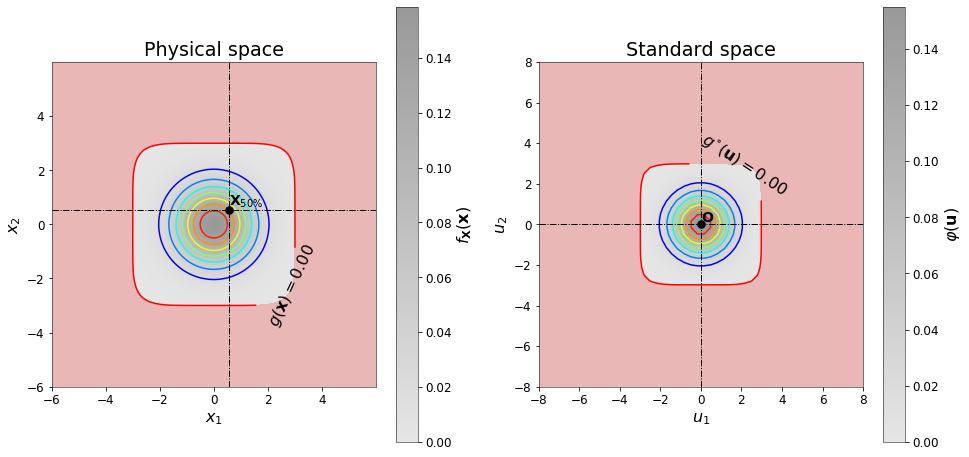

In [13]:
fig = plt.figure(figsize=(16, 8))
ax, data_plot = plot_in_physical_space(res=100, ax=fig.add_subplot(121))
ax.contour(data_plot['x1_plot'], data_plot['x2_plot'], data_plot['fx_plot'], cmap=plt.matplotlib.cm.jet)
ax, data_plot_st = plot_in_standard_space(ax=fig.add_subplot(122), lim=8.)
ax.contour(data_plot_st['u1_plot'], data_plot_st['u2_plot'], data_plot_st['fu_plot'], cmap=plt.matplotlib.cm.jet)
fig.show()

** Surface dans l'espace physique**

/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


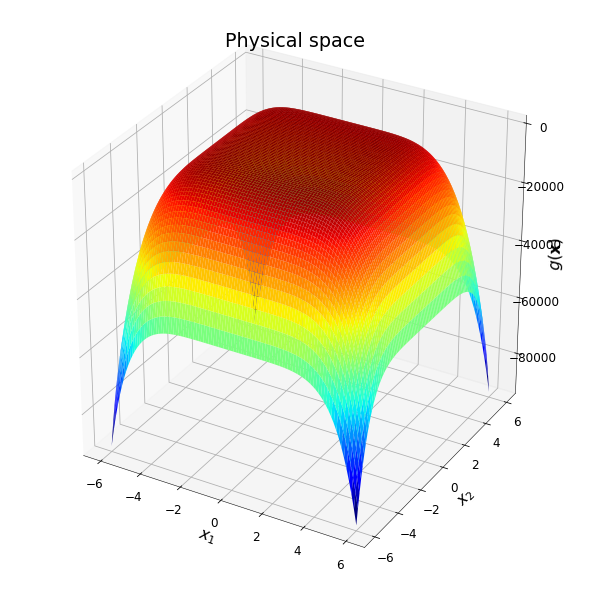

In [14]:
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig)
ax.plot_surface(data_plot['x1_plot'], data_plot['x2_plot'], data_plot['gx_plot'],
                cmap=plt.matplotlib.cm.jet, rstride=1, cstride=1, lw=0.)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$g(\mathbf{x})$')
ax.set_title('Physical space')
fig.show()

** Surface dans l'espace standard **

/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


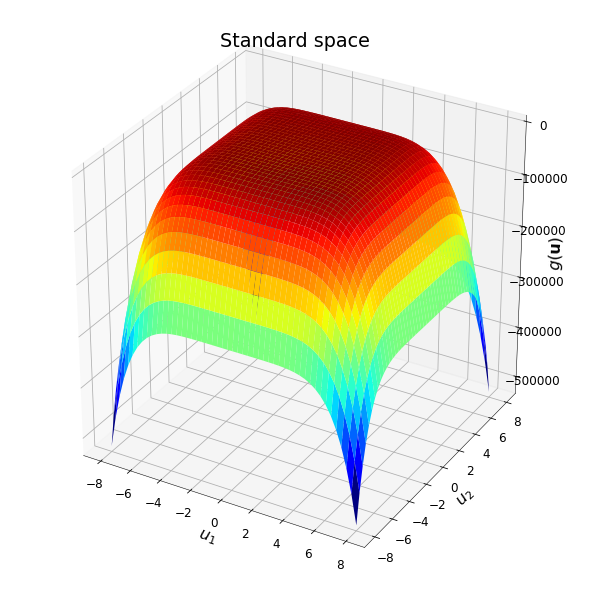

In [15]:
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig)
ax.plot_surface(data_plot_st['u1_plot'], data_plot_st['u2_plot'], data_plot_st['gu_plot'],
                cmap=plt.matplotlib.cm.jet, rstride=1, cstride=1, lw=0.)
ax.set_xlabel('$u_1$')
ax.set_ylabel('$u_2$')
ax.set_zlabel('$g(\mathbf{u})$')
ax.set_title('Standard space')
fig.show()

La transformation isoprobabiliste **conserve les probabilités**, donc la probabilité de défaillance calculée dans l'espace physique est **la même** que celle calculée dans l'espace standard. Néanmoins, ses approximations peuvent être différentes d'un espace à l'autre car la géométrie n'est pas la même.

# 3. Estimation par simple simulation de Monte Carlo

La simulation de Monte Carlo est la méthode d'estimation de référence. Néanmoins, son coût de calcul est inversement proportionnel à la probabilité à estimer, ce qui la rend tout simplement inapplicable dès lors que la probabilité est faible et le modèle coûteux à évaluer.

L'estimateur par simulation de Monte Carlo simple est la **moyenne empirique de la fonction indicatrice de défaillance**:
\begin{equation}
    \widehat{P}_{f, MCS} = \frac{1}{N} \sum_{i=1}^{N} \mathbb I_F (\mathbf X^{(i)})
\end{equation}

Selon le théorème central limite, cet **estimateur est sans biais** et converge comme suit:
\begin{equation}
    \widehat{P}_{f, MCS} \underset{N \to \infty}{\sim} \mathcal N \left(p_f, \sqrt{\frac{p_f (1 - p_f)}{N}} \right)
\end{equation}

Le **nombre de simulations requis croit rapidement** à mesure que l’ordre de grandeur de la probabilité diminue. Le coefficient de variation se calcule comme suit:

\begin{equation}
    \delta = \sqrt{\frac{1-p_f}{N  p_f}} \approx \frac{1}{\sqrt{N p_f}}
\end{equation}

Pour un coefficient cible de 10 % : $p_f \approx 10^{-k} \Rightarrow N_{min} \approx 10^{k+2}$.

In [16]:
# Activation de l'historique
g.enableHistory()
g.clearHistory()

In [17]:
# create a Monte Carlo algorithm
experiment = ot.MonteCarloExperiment()
MCS_algorithm = ot.ProbabilitySimulationAlgorithm(failure_event, experiment)
MCS_algorithm.setMaximumCoefficientOfVariation(.1)
MCS_algorithm.setMaximumOuterSampling(40000)
MCS_algorithm.setBlockSize(100)
MCS_algorithm.run()
MCS_results = MCS_algorithm.getResult()
MCS_evaluation_number = g.getInputHistory().getSize()

In [18]:
# Création de l'objet MonteCarlo
experiment = ot.MonteCarloExperiment()
MCS_algorithm = ot.ProbabilitySimulationAlgorithm(failure_event, experiment)

# Fixe le coefficient de variation maximum à 10%
MCS_algorithm.setMaximumCoefficientOfVariation(.1)

# Fixe le nombre de tirage à MaximumOuterSampling x BlockSize
MCS_algorithm.setMaximumOuterSampling(int(1e4))
# Blocksize permet d'envoyer par paquet les points à évaluer
MCS_algorithm.setBlockSize(int(1e3))
ot.Log.SetFile('file.log')
ot.Log.Show(ot.Log.INFO)

# Lancement de la simulation
MCS_algorithm.run()
MCS_results = MCS_algorithm.getResult()

# Récupération du nombre d'évaluations
MCS_evaluation_number = g.getInputHistory().getSize()

In [19]:
print('Probability estimate: %.3e' % MCS_results.getProbabilityEstimate())
print('Coefficient of variation: %.2f' % MCS_results.getCoefficientOfVariation())
print('Number of evaluations: %d' % MCS_evaluation_number)

Probability estimate: 6.438e-03
Coefficient of variation: 0.10
Number of evaluations: 34800


** Convergence de la probabilité de défaillance**

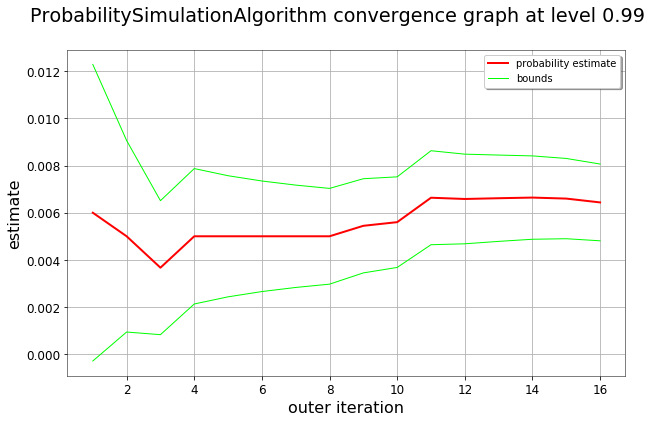

In [20]:
View(MCS_algorithm.drawProbabilityConvergence(0.99), figure_kwargs={'figsize':(10,6)}).show()

**Affichage des tirages dans les espaces physique et standard**

/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'lw'
/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'lw'
  from ipykernel import kernelapp as app
/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


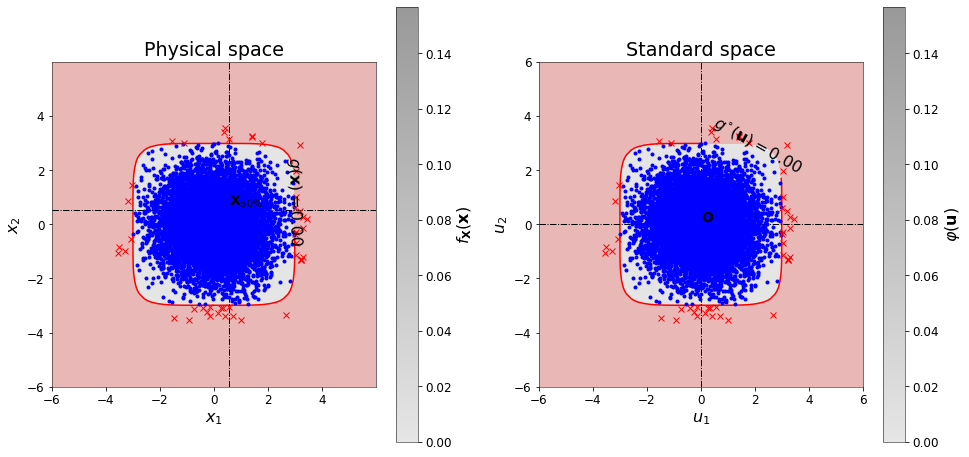

In [21]:
fig = plt.figure(figsize=(16, 8))

# Récupération des tirages et la valeur de g en ces points
input_sample = np.array(g.getInputHistory())[:int(1e4)]
output_sample = np.ravel(g.getOutputHistory())[:int(1e4)]

# Plot espace physique
ax, data_plot = plot_in_physical_space(ax=fig.add_subplot(121))
ax.plot(input_sample[output_sample > 0., 0], input_sample[output_sample > 0., 1], 'b.')
ax.plot(input_sample[output_sample <= 0., 0], input_sample[output_sample <= 0., 1], 'rx')

# plot espace standard
ax, data_plot = plot_in_standard_space(ax=fig.add_subplot(122))
# Attention, il faut utiliser la méthode getIsoProbabilisticTransformation pour transformer
# les variables d'entrée dans l'espace standard
input_sample = np.array(input_distribution.getIsoProbabilisticTransformation()(input_sample))
ax.plot(input_sample[output_sample > 0., 0], input_sample[output_sample > 0., 1], 'b.')
ax.plot(input_sample[output_sample <= 0., 0], input_sample[output_sample <= 0., 1], 'rx')
fig.show()

**Affichage de la CDF empirique**

/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


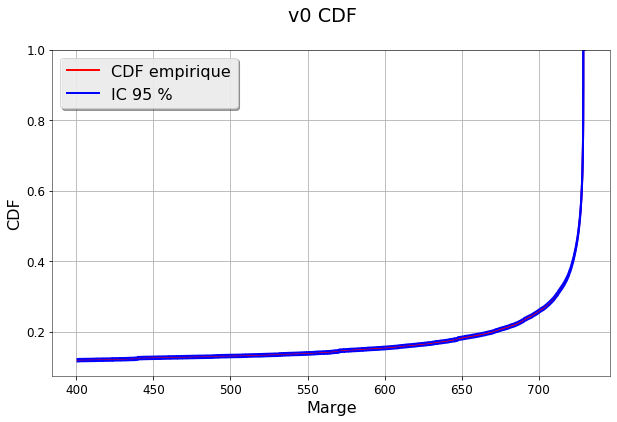

In [22]:
# Récupération des sorties dans l'historique
sample_G = g.getOutputHistory()

# Graphe de la CDF empirique avec OpenTURNS
min_G = sample_G.getMin()[0]
max_G = sample_G.getMax()[0]
graph = ot.UserDefined(sample_G).drawCDF()

# Récupération des données calculées
data = np.array(graph.getDrawables()[0].getData())

# Calcul de l'intervalle de confiance pour chaque pf
cov = np.sqrt((1. - data[:, 1]) / float(data.shape[0]) / data[:, 1])
ic_inf = data[:, 1] * (1. - 1.96 * cov)
ic_sup = data[:, 1] * (1. + 1.96 * cov)

fig, ax = plt.subplots(figsize=(10, 6))
#ax.set_yscale('log')
View(graph, axes=[ax])
ax.plot(data[:, 0], ic_inf, 'b-', drawstyle='steps-post', lw=2.)
ax.plot(data[:, 0], ic_sup, 'b-', drawstyle='steps-post', lw=2.)
ax.fill_between(np.hstack(data[:, 0]), ic_inf, ic_sup, facecolor='b', alpha=.2)
ax.set_xlabel('Marge')
ax.set_ylim(ymax=1)
ax.legend(['CDF empirique', 'IC 95 %'], loc='upper left')
fig.show()

# 4. Approches basées sur le point de défaillance le plus probable

## 4.1. Recherche du point de défaillance le plus probable (MPFP)

On appelle le point de défaillance le plus probable, noté $P^*$, le **point le plus proche de l'origine qui appartient au domaine de défaillance**. Ce point n'est pas nécessairement unique, mais c'est souvent le cas sur des modèles physique "simples". On cherche à trouver $\mathbf u^*$ tel que :

\begin{equation}
    \mathbf u^* = \text{arg}\min_{u \in \mathbb R^n} \mathbf u^t \mathbf u : g^°(\mathbf u) \leq 0
\end{equation}

Il existe plusieurs algorithmes de recherche dédiés à la recherche de ce point. OpenTURNS implémente 3 algorithmes :

- **Abdo-Rackwitz** : algorithme d'ordre 1 avec une recherche du pas de descente optimale,
- **SQP** : algorithme d'ordre 2 avec une recherche du pas de descente optimale,
- **Cobyla** : algorithme d'ordre 0, les contraintes sont linéarisées.

avec 4 critères d'arrêt :

- Erreur absolue : $e_{abs} = ||\mathbf u_{i+1} - \mathbf u_{i}||$
- Erreur relative : $e_{rel} = ||\mathbf u_{i+1} - \mathbf u_{i}|| / ||\mathbf u_{i+1}||$
- Erreur de contrainte : $e_{cons} = |g^°(\mathbf u_{i+1})|$
- Erreur résiduelle : $e_{res} = ||\mathbf u_{i+1} - \mathbf u_{i} - d||$

où $i$ est l'itération courante de l'algorithme et $d$ la direction de descente de l'algorithme. Les critères sont couplés deux à deux : soit les critères sur l’erreur absolue et l’erreur relative sont validés, soit les critères sur l’erreur de contrainte et l’erreur résiduelle sont validés. La valeur maximum par défaut est fixée à $10^{-5}$.

N.B. : l'**erreur sur la contrainte** correspond à la **valeur de la fonction de performance** au point de l'itération courante. Si la fonction $g^°$ n'est pas définie de façon conventionnelle (i.e. $g^°$ s'annule sur l'état-limite), il faut modifier ce critère d'arrêt avec une valeur de l'ordre de grandeur de la sortie pour avoir une convergence.

In [23]:
g.enableHistory()
g.clearHistory()

In [24]:
# Spécification de la fonction contrainte, dans l'espace standard !!!
Tinv = input_distribution.getInverseIsoProbabilisticTransformation()

# Définition du problème d'optimisation
gt = ot.ComposedFunction(g, Tinv)
optimProblem = ot.NearestPointProblem(gt, 0.)

## Algorithme AbdoRackwitz
design_point_algorithm = ot.AbdoRackwitz(optimProblem)

## Point de départ
design_point_algorithm.setStartingPoint([0., 0.])

## Lancement
design_point_algorithm.run()

## Récupération des résultats
search_results = design_point_algorithm.getResult()
design_point_in_standard_space = search_results.getOptimalPoint()
design_point_in_physical_space = Tinv(design_point_in_standard_space)
iteration_input_in_standard_space = search_results.getInputSample()
iteration_input_in_physical_space = Tinv(iteration_input_in_standard_space)

/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'lw'
/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'lw'
  from ipykernel import kernelapp as app
/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


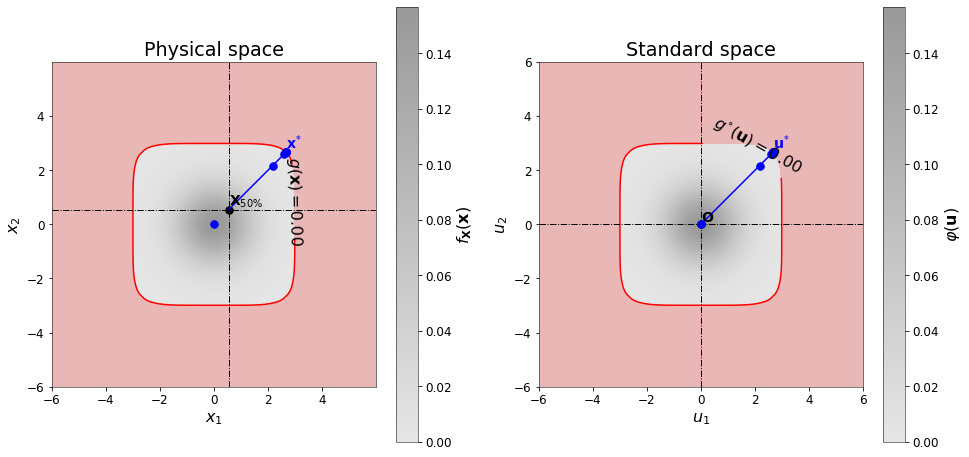

In [25]:
fig = plt.figure(figsize=(16, 8))
# plot espace physique
ax, data_plot = plot_in_physical_space(ax=fig.add_subplot(121))
ax.plot(iteration_input_in_physical_space[:, 0],
        iteration_input_in_physical_space[:, 1], 'b.', markersize=15)
ax.plot([input_distribution.computeQuantile(.5)[0], design_point_in_physical_space[0]],
        [input_distribution.computeQuantile(.5)[1], design_point_in_physical_space[1]], 'b-')
ax.plot(design_point_in_physical_space[0], design_point_in_physical_space[1],
        'b.', markersize=15)
plt.text(design_point_in_physical_space[0], design_point_in_physical_space[1],
        '$\mathbf{x}^{*}$', ha='left', va='bottom', color='b', fontdict={'fontsize': 14})

# plot espace standard
ax, data_plot = plot_in_standard_space(ax=fig.add_subplot(122))
ax.plot(iteration_input_in_standard_space[:, 0],
        iteration_input_in_standard_space[:, 1], 'b.', markersize=15)
ax.plot([0., design_point_in_standard_space[0]],
        [0., design_point_in_standard_space[1]], 'b-')
ax.plot(design_point_in_standard_space[0], design_point_in_standard_space[1],
        'b.', markersize=15)
plt.text(design_point_in_standard_space[0], design_point_in_standard_space[1],
        '$\mathbf{u}^{*}$', ha='left', va='bottom', color='b', fontdict={'fontsize': 14})
fig.show()

## 4.2. First order reliability method (FORM)

On fait l'**hypothèse** que le point de défaillance le plus probable $P^*$ est **unique**. La fonction de performance est approximée par un développement de **Taylor au premier ordre** au voisinage de ce point.

\begin{equation}
    g^°_{1, \mathbf u^*} = g^°(\mathbf u^*) + \nabla_{\mathbf u}g^°(\mathbf u^*)^t(\mathbf u - \mathbf u^*) = \nabla_{\mathbf u}g^°(\mathbf u^*)^t(\mathbf u - \mathbf u^*)
\end{equation}

On définit le vecteur (normé) des **cosinus directeurs** :
\begin{equation}
    \boldsymbol \alpha = \frac{\nabla_{\mathbf u}g^°(\mathbf u^*)}{||\nabla_{\mathbf u}g^°(\mathbf u^*)||_2}
\end{equation}

Ainsi que l'**indice de fiabilité** d'Hasofer-Lind :
\begin{equation}
    \beta_{HL} = - \boldsymbol \alpha^t \mathbf u^* = \overline{OP^*}
\end{equation}

La probabilité de défaillance est approximée par la relation suivante (vraie lorsque l'état-limite est linéaire dans l'espace standard) :
\begin{equation}
    p_{f, FORM} = \Phi (-\beta_{HL})
\end{equation}
où $\Phi$ est la fonction de répartition inverse de la loi normale.

OpenTURNS implémente la méthode FORM à travers l'objet `FORM` qui prend en arguments :

- l'algorithme de recherche de $P^*$, il n'y a pas besoin de définir les arguments. Donner un constructeur vide fonctionne mais il est toutefois préférable de bien fixer les critères d'arrêt.
- l'événement de la défaillance
- le point de départ de l'algorithme.

In [26]:
g.enableHistory()
g.enableCache()
g.clearHistory()

In [27]:
# Création de l'objet FORM
FORM_algorithm = ot.FORM(ot.AbdoRackwitz(), failure_event, input_distribution.computeQuantile(.5))
ot.Log.SetFile('file.log')
ot.Log.Show(ot.Log.INFO)
# Lancement du calcul
FORM_algorithm.run()

# Récupération des résultats
FORM_results = FORM_algorithm.getResult()
FORM_optim = FORM_results.getOptimizationResult()
FORM_evaluation_number = g.getInputHistory().getSize()

In [28]:
print('Hasofer-Lind reliability index: %.2f' % FORM_results.getHasoferReliabilityIndex())
print('First-order approximation of the probability: %.3e' % FORM_results.getEventProbability())
print('Iteration number: %i' % FORM_optim.getIterationNumber())
print('Number of evaluations: %d' % FORM_evaluation_number)

Hasofer-Lind reliability index: 3.78
First-order approximation of the probability: 7.849e-05
Iteration number: 6
Number of evaluations: 35


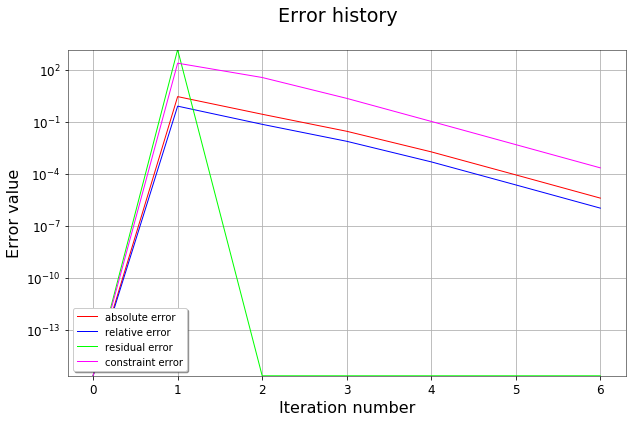

In [29]:
View(FORM_optim.drawErrorHistory(), legend_kwargs={'loc':'lower left'},
                                    figure_kwargs={'figsize':(10, 6)}).show()

In [30]:
def g0py(u):
    g0 = g.gradient(Tinv(design_point_in_standard_space)).transpose() * (u - design_point_in_standard_space)
    return g0

gapprox = ot.PythonFunction(2, 1, g0py)

/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'lw'
/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'lw'
  from ipykernel import kernelapp as app


TypeError: unsupported operand type(s) for -: 'openturns.memoryview.Buffer' and 'Point'

RuntimeError: InternalException : Python exception: TypeError: unsupported operand type(s) for -: 'openturns.memoryview.Buffer' and 'Point'

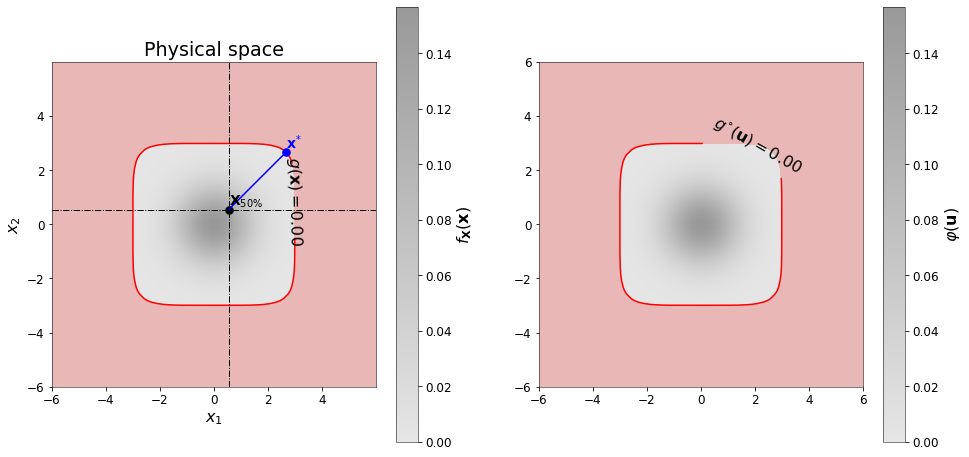

In [31]:
fig = plt.figure(figsize=(16, 8))
# plot espace physique
ax, data_plot = plot_in_physical_space(ax=fig.add_subplot(121))
#ax.plot(iteration_input_in_physical_space[:, 0],
#        iteration_input_in_physical_space[:, 1], 'b.', markersize=15)
ax.plot([input_distribution.computeQuantile(.5)[0], design_point_in_physical_space[0]],
        [input_distribution.computeQuantile(.5)[1], design_point_in_physical_space[1]], 'b-')
ax.plot(design_point_in_physical_space[0], design_point_in_physical_space[1],
        'b.', markersize=15)
plt.text(design_point_in_physical_space[0], design_point_in_physical_space[1],
        '$\mathbf{x}^{*}$', ha='left', va='bottom', color='b', fontdict={'fontsize': 14})

# plot espace standard
ax, data_plot = plot_in_standard_space(ax=fig.add_subplot(122), approx=gapprox)
#ax.plot(iteration_input_in_standard_space[:, 0],
#        iteration_input_in_standard_space[:, 1], 'b.', markersize=15)
ax.plot([0., design_point_in_standard_space[0]],
        [0., design_point_in_standard_space[1]], 'b-')
ax.plot(design_point_in_standard_space[0], design_point_in_standard_space[1],
        'b.', markersize=15)
plt.text(design_point_in_standard_space[0], design_point_in_standard_space[1],
        '$\mathbf{u}^{*}$', ha='left', va='bottom', color='b', fontdict={'fontsize': 14})
fig.show()

## 4.3. Second-order reliability method (SORM)

SORM prend en compte **les courbures locales de l'état-limite**. Pour cela, il est nécessaire de pouvoir calculer les **dérivées secondes de la fonction de performance dans l'espace standard**. Le développement de Taylor est construit à l'ordre 2 au voisinage de $P^*$.

Plusieurs formulations existent pour prendre en compte les courbures dans le calcul de la probabilité de défaillance. OpenTURNS implémente les 3 méthodes de calcul :
- Breitung
- Hohen-Bichler
- Tvedt

Si les courbures sont trop importantes, le calcul n'est pas réalisable. Dans le cas contraire où les courbures sont nulles, on retrouve l'approximation FORM.

In [32]:
g.enableHistory()
g.clearHistory()

In [33]:
SORM_algorithm = ot.SORM(design_point_algorithm, failure_event, input_distribution.computeQuantile(.5))
SORM_algorithm.run()
SORM_results = SORM_algorithm.getResult()
SORM_optim = SORM_results.getOptimizationResult()
SORM_evaluation_number = g.getEvaluationCallsNumber()

In [34]:
print('Breitung reliability index: %.2f' % SORM_results.getGeneralisedReliabilityIndexBreitung())
print('Breitung second-order approximation of the probability: %.3e' % SORM_results.getEventProbabilityBreitung())
print('______')
print('Hohen-Bichler reliability index: %.2f' % SORM_results.getGeneralisedReliabilityIndexHohenBichler())
print('Hohen-Bichler second-order approximation of the probability: %.3e' % SORM_results.getEventProbabilityHohenBichler())
print('______')
print('Tvedt reliability index: %.2f' % SORM_results.getGeneralisedReliabilityIndexTvedt())
print('Tvedt second-order approximation of the probability: %.3e' % SORM_results.getEventProbabilityTvedt())
print('______')
print('Iteration number: %i' % SORM_optim.getIterationNumber())
print('Number of evaluations: %d' % SORM_evaluation_number)

RuntimeError: NotDefinedException : Error: impossible to compute Breitung SORM probability, one of the curvatures is < -1/beta. beta=3.77976, curvature=-1.26407

## 4.4. Echantillonnage préférentiel au point de défaillance le plus probable (Tirages d'importance, MPFP-IS)

Une autre correction peut être obtenue par **échantillonnage préférentiel au
voisinage du point de conception $P^*$** identifié. Pour ce faire, on utilise une densité instrumentale dans l’espace standard : la loi multinormale de moyenne les coordonnées $\mathbf u^*$ et de matrice de corrélation l'identité :

\begin{equation}
    \varphi_{n, \mathbf u^*} (\mathbf u) = \varphi_n (\mathbf u - \mathbf u^*) = \frac{1}{(2 \pi)^{n/2}} \exp \left( - \frac{(\mathbf u - \mathbf u^*)^t(\mathbf u - \mathbf u^*)}{2} \right)
\end{equation}

L’estimateur de la probabilité de défaillance se simplifie comme suit :

\begin{equation}
    \widehat{P}_{f,IS} = \frac{\exp(-\beta_{HL}^2/2)}{N} \sum_{i=1}^{N} \mathbb I_{\mathbb F^°}(\mathbf Z^{(i)}) \exp (- \mathbf Z^{(i)t} \mathbf u^*)
\end{equation}

Il est sans biais si le **point de conception est unique**. Il **« converge » très rapidement**, car les points simulés suivant la densité
instrumentale ont un taux de défaillance proche de 50% (entre 10 et 90%).


In [35]:
g.enableHistory()
g.clearHistory()

In [36]:
# Création de la densité instrumentale
instrumental_distribution = ot.Normal(design_point_in_standard_space, [1.] * 2, ot.CorrelationMatrix(2))

# Création de l'objet ImportanceSampling avec :
#  - l'événement dans l'espace standard (--> fonction de performance définie dans l'espace standard)
#  - la densité instrumentale
experiment = ot.ImportanceSamplingExperiment(instrumental_distribution)
IS_algorithm = ot.ProbabilitySimulationAlgorithm(failure_event, experiment)
IS_algorithm.setMaximumCoefficientOfVariation(.05)
IS_algorithm.setMaximumOuterSampling(int(1e3))
IS_algorithm.setBlockSize(int(1e1))
IS_algorithm.run()
IS_results = IS_algorithm.getResult()
IS_evaluation_number = g.getEvaluationCallsNumber()

In [37]:
print('Probability estimate: %.3e' % IS_results.getProbabilityEstimate())
print('Coefficient of variation: %.2f' % IS_results.getCoefficientOfVariation())
print('Number of evaluations: %d' % IS_evaluation_number)

Probability estimate: 2.216e-03
Coefficient of variation: 0.18
Number of evaluations: 72420


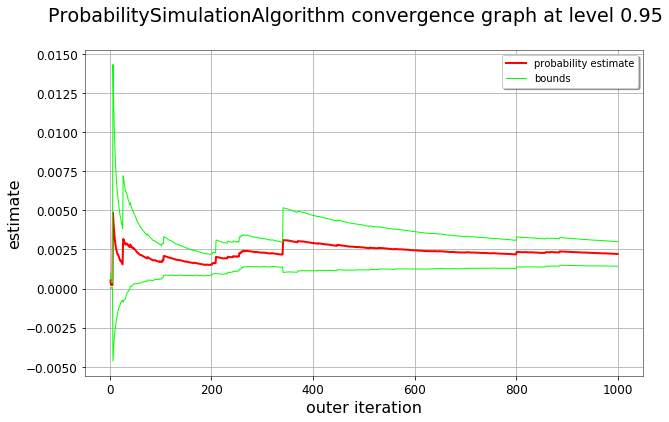

In [38]:
View(IS_algorithm.drawProbabilityConvergence(), figure_kwargs={'figsize':(10,6)}).show()

/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'lw'
/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'lw'
  from ipykernel import kernelapp as app
/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


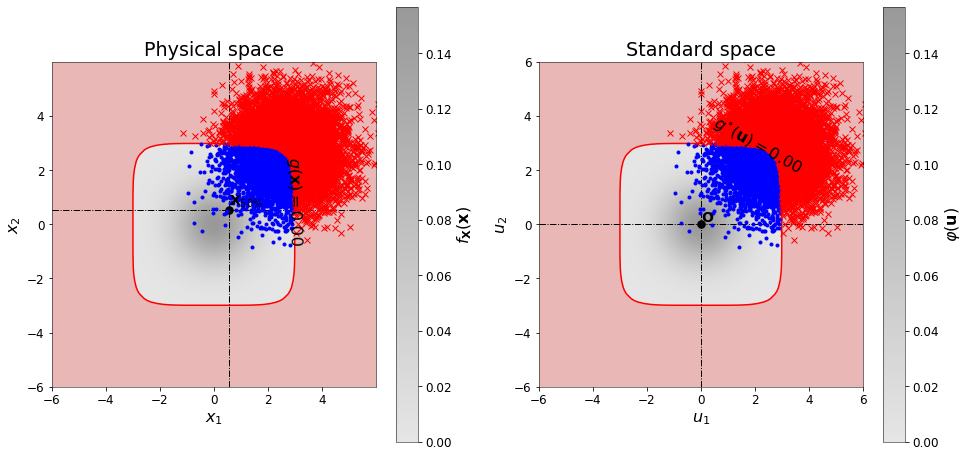

In [39]:
fig = plt.figure(figsize=(16, 8))
input_sample = np.array(g.getInputHistory())
output_sample = np.ravel(g.getOutputHistory())
ax, data_plot = plot_in_physical_space(ax=fig.add_subplot(121))
ax.plot(input_sample[output_sample > 0., 0], input_sample[output_sample > 0., 1], 'b.')
ax.plot(input_sample[output_sample <= 0., 0], input_sample[output_sample <= 0., 1], 'rx')
ax, data_plot = plot_in_standard_space(ax=fig.add_subplot(122))
input_sample = np.array(input_distribution.getIsoProbabilisticTransformation()(input_sample))
ax.contour(data_plot['u1_plot'], data_plot['u2_plot'],
           np.reshape(instrumental_distribution.computePDF(data_plot['uu_plot']),
                      data_plot['u1_plot'].shape),
           cmap=plt.matplotlib.cm.jet)
ax.plot(input_sample[output_sample > 0., 0], input_sample[output_sample > 0., 1], 'b.')
ax.plot(input_sample[output_sample <= 0., 0], input_sample[output_sample <= 0., 1], 'rx')
fig.show()

# 5. Estimation par simulations directionnelles

La probabilité de défaillance est décomposée comme une somme de probabilité conditionnée à une direction donnée $\delta$. L'objectif est de **rechercher les intersections de la direction $\delta$** avec la surface d'état-limite. L'opération est répétée suivant un nombre $N$ donné de **directions uniformément reparties sur l'hypersphère**. 

La réduction du nombre de simulations par rapport à Monte Carlo est importante, notamment lorsque la défaillance entoure l'origine. Il est possible d'identifier des points $P^*$ a posteriori (s'il y en a plusieurs).

Cependant, cette méthode **perd de son efficacité en grande dimension**. Il est recommandé de l'utiliser pour des problèmes avec moins de $n=5$ variables.

OpenTURNS implémente plusieurs techniques de recherche (stratégies + solver) des intersections.

In [40]:
g.enableHistory()
g.clearHistory()
# Stratégie de recherche de l'intersection
root_strategy = ot.SafeAndSlow() # Alternatives : ot.SafeAndSlow(), ot.MediumSafe(), ot.RiskyAndFast()
# Choix du solver
solver = ot.Brent() # Alternatives : ot.Bisection(), ot.Secant(), ot.Brent()
root_strategy.setSolver(solver)
# Choix de l'échantillonnage des directions
sampling_strategy = ot.OrthogonalDirection() # Alternatives : ot.RandomDirection(), ot.OrthogonalDirection()
sampling_strategy.setDimension(input_distribution.getDimension())

# Création de l'objet DirectionalSampling
DS_algorithm = ot.DirectionalSampling(failure_event)
DS_algorithm.setMaximumCoefficientOfVariation(.05)
DS_algorithm.setMaximumOuterSampling(int(1e5))
DS_algorithm.setBlockSize(int(1e0))
DS_algorithm.setRootStrategy(root_strategy)
DS_algorithm.setSamplingStrategy(sampling_strategy)
DS_algorithm.run()
DS_results = DS_algorithm.getResult()
DS_evaluation_number = g.getEvaluationCallsNumber()

In [41]:
print('Probability estimate: %.3e' % DS_results.getProbabilityEstimate())
print('Coefficient of variation: %.2f' % DS_results.getCoefficientOfVariation())
print('Number of evaluations: %d' % DS_evaluation_number)

Probability estimate: 5.647e-03
Coefficient of variation: 0.05
Number of evaluations: 87129


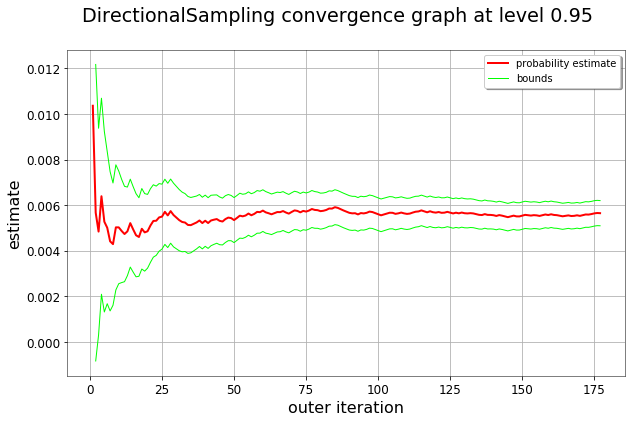

In [42]:
View(DS_algorithm.drawProbabilityConvergence(), figure_kwargs={'figsize':(10,6)}).show()

/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'lw'
/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'lw'
  from ipykernel import kernelapp as app
/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


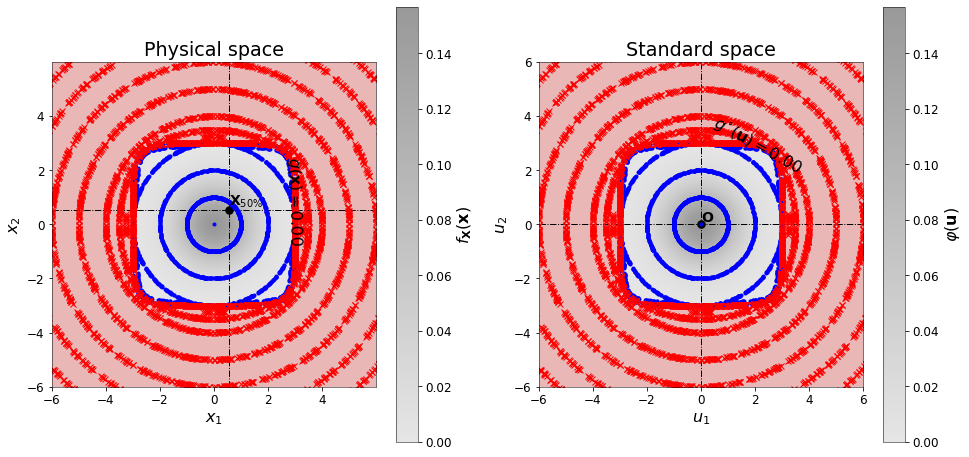

In [43]:
input_sample = np.array(g.getInputHistory())
output_sample = np.ravel(g.getOutputHistory())
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121)
ax, data_plot = plot_in_physical_space(ax=ax)
ax.plot(input_sample[output_sample > 0., 0], input_sample[output_sample > 0., 1], 'b.')
ax.plot(input_sample[output_sample <= 0., 0], input_sample[output_sample <= 0., 1], 'rx')
ax = fig.add_subplot(122)
ax, data_plot = plot_in_standard_space(ax=ax)
input_sample = np.array(input_distribution.getIsoProbabilisticTransformation()(input_sample))
ax.plot(input_sample[output_sample > 0., 0], input_sample[output_sample > 0., 1], 'b.')
ax.plot(input_sample[output_sample <= 0., 0], input_sample[output_sample <= 0., 1], 'rx')
fig.show()

# 6. Estimation par subset sampling

On définit une collection de **valeurs strictement décroissante** dont le dernier élément est 0 : $y_1 > y_2 > \ldots > y_m = 0$. Ces valeurs correspondent au seuil de la fonction de performance.

Des **sous-ensembles** (de défaillances) sont associés à chaque valeur de la collection : $\mathbb F_i = \left\{ \{ \mathbf x \in \mathbb X : g(\mathbf x) \leq y_i \}, i=1, \ldots, m \right\}$. Chaque sous-ensemble est inclut dans l'autre :

\begin{equation}
    \mathbb F_1 \supset \mathbb F_2 \supset \ldots \supset \mathbb F_m = \mathbb F
\end{equation}
où $\mathbb F$ correspond au vrai domaine de défaillance.

La probabilité de défaillance est **décomposée** en utilisant la propriété d'inclusion :

\begin{equation}
    p_{f,SS} = \text{Prob} [\mathbb F_1] \prod_{i=2}^m \text{Prob} [\mathbb F_i | \mathbb F_{i-1}]
\end{equation}

En pratique, plutôt que d’estimer les probabilités conditionnelles, on se les donne toutes
égales à $\alpha$, et on **cherche la valeur des seuils $\mathbf y$ comme le quantile au niveau $\alpha$**. Pour minimiser le nombre de tirages par pas et le nombre de pas, il vaut mieux se limiter à la plage 10-20%.

\begin{eqnarray}
    y_1 : & \text{Prob} [\mathbb F_1] = \alpha & \\
    y_i : & \text{Prob} [\mathbb F_i | \mathbb F_{i-1}] = \alpha & i = 2, \ldots, m
\end{eqnarray}

Un **algorithme MCMC**, initialisé avec les individus défaillants, est utilisé pour échantillonner au pas suivant en direction de la défaillance. Les incréments s'arrête lorsqu'un seuil négatif est déterminé, dans ce cas, il est remplacé par $y_m=0$.

C'est une méthode **très efficace et robuste** si on peut se permettre quelques dizaines de milliers de calculs de la fonction de performance. Cependant, l'estimateur de la probabilité de défaillance est **biaisé quel que soit $N$**. Il est souvent insignifiant mais peut être significatif sur des cas "complexes".

In [44]:
g.enableHistory()
g.clearHistory()

In [45]:
SS_algorithm = ot.SubsetSampling(failure_event)
# Active la simulation conditionnelle à l'étape initiale
SS_algorithm.setBetaMin(2)
SS_algorithm.setISubset(False) # 1 : activée, 0 : désactivée
# -------------------------------------------------------
# Maximum tirages par step = OuterSampling x BlockSize
SS_algorithm.setMaximumOuterSampling(int(1e2))
SS_algorithm.setBlockSize(int(1e2))
SS_algorithm.setMaximumCoefficientOfVariation(0.1)
SS_algorithm.setConditionalProbability(0.1)
# Choix de la stratégie pour l'historique
SS_algorithm.setConvergenceStrategy(ot.Last(3*100)) # Alternatives : Full, Compact(N), Last(N), Null
SS_algorithm.run()
SS_results = SS_algorithm.getResult()
SS_evaluation_number = g.getEvaluationCallsNumber()

In [46]:
print('Probability estimate: %.3e' % SS_results.getProbabilityEstimate())
print('Coefficient of variation: %.2f' % SS_results.getCoefficientOfVariation())
print('Number of steps : %d' % SS_algorithm.getNumberOfSteps())
print('Number of evaluations: %d' % SS_evaluation_number)

Probability estimate: 5.796e-03
Coefficient of variation: 0.06
Number of steps : 3
Number of evaluations: 121320


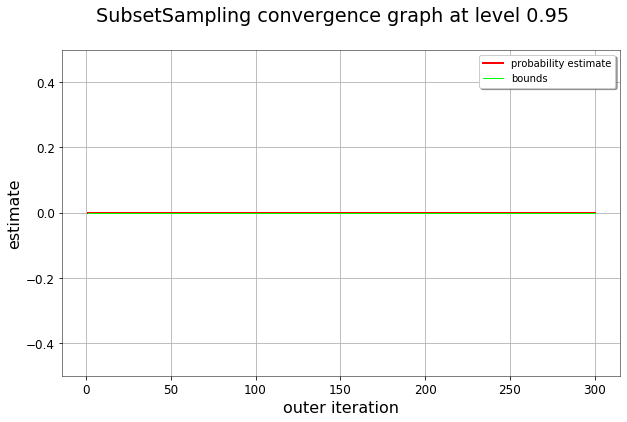

In [47]:
View(SS_algorithm.drawProbabilityConvergence(), figure_kwargs={'figsize':(10,6)}).show()

/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'lw'
  from ipykernel import kernelapp as app


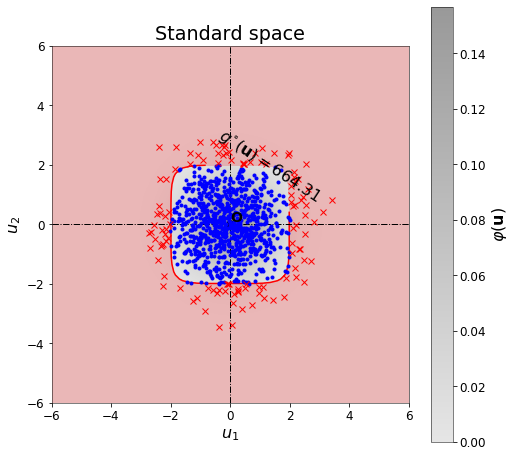

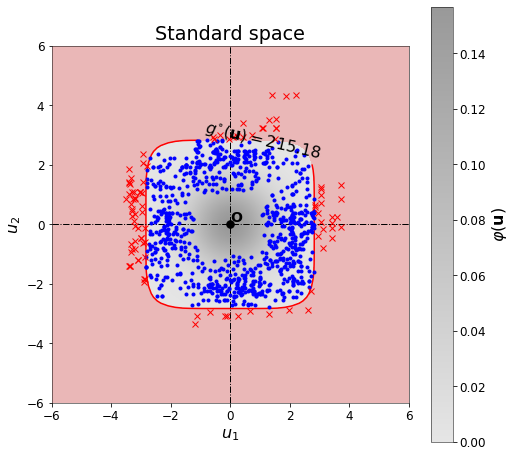

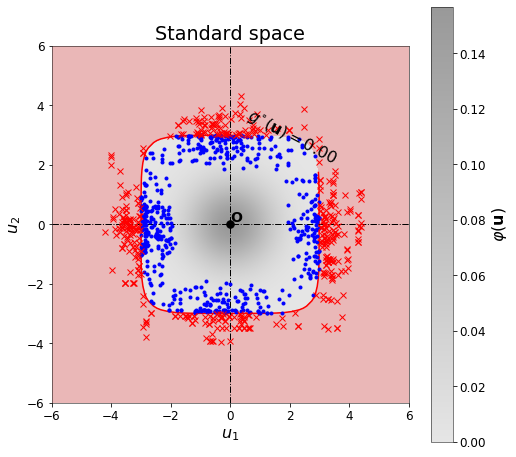

In [48]:
for step in range(SS_algorithm.getNumberOfSteps()):
    N = SS_algorithm.getMaximumOuterSampling() * SS_algorithm.getBlockSize()
    thresholds = SS_algorithm.getThresholdPerStep()
    
    input_sample = np.array(g.getInputHistory())[step * N:(step + 1) * N:10]
    input_sample = np.array(input_distribution.getIsoProbabilisticTransformation()(input_sample))
    
    output_sample = np.ravel(g.getOutputHistory())[step * N:(step + 1) * N:10]
    
    ax, data_plot = plot_in_standard_space(g0=thresholds[step])
    ax.plot(input_sample[output_sample > thresholds[step], 0],
            input_sample[output_sample > thresholds[step], 1], 'b.')
    _ = ax.plot(input_sample[output_sample <= thresholds[step], 0],
                input_sample[output_sample <= thresholds[step], 1], 'rx')

/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.
/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'lw'
/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'lw'
  # Remove the CWD from sys.path while we load stuff.
/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: No contour levels were found within the data range.
  from ipykernel import kernelapp as app
/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'lw'
  from ipykernel import kernelapp as app
/home/blondet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: The following kwargs were not used by contour: 'lw'


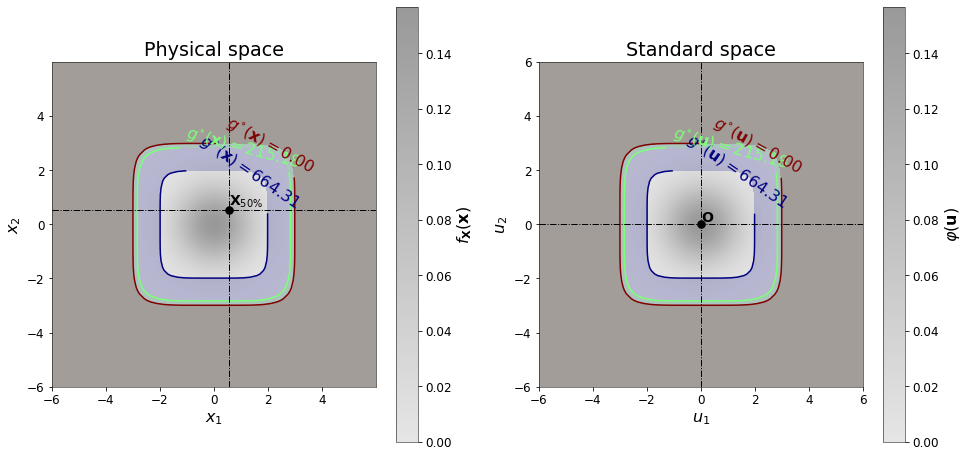

In [49]:
thresholds = np.ravel(SS_algorithm.getThresholdPerStep())
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121)
ax, data_plot = plot_in_physical_space(g0=-1e6, ax=ax)
colors = plt.matplotlib.cm.jet(np.linspace(0, 1., thresholds.size))
for threshold, color in zip(thresholds, colors):
    c = ax.contourf(data_plot['x1_plot'], data_plot['x2_plot'], data_plot['gx_plot'],
                    [-np.inf, threshold], colors=[color], alpha=.2)
    c = ax.contour(data_plot['x1_plot'], data_plot['x2_plot'], data_plot['gx_plot'],
                   [threshold], colors=[color], linestyles='solid', lw=2.)
    plt.clabel(c, fmt=FormatFaker('$g^{\circ}(\mathbf{x}) = %.2f$' % threshold))
    
ax = fig.add_subplot(122)
ax, data_plot = plot_in_standard_space(g0=-1e6, ax=ax)
colors = plt.matplotlib.cm.jet(np.linspace(0, 1., thresholds.size))
for threshold, color in zip(thresholds, colors):
    c = ax.contourf(data_plot['u1_plot'], data_plot['u2_plot'], data_plot['gu_plot'],
                    [-np.inf, threshold], colors=[color], alpha=.2)
    c = ax.contour(data_plot['u1_plot'], data_plot['u2_plot'], data_plot['gu_plot'],
                    [threshold], colors=[color], linestyles='solid', lw=2.)
    plt.clabel(c, fmt=FormatFaker('$g^{\circ}(\mathbf{u}) = %.2f$' % threshold))
